# PROJECT
## AMAZON EMPLOYEE ACCESS CHALLENGE

## Table of Content

1. [Problem Statement](#section1)<br>
2. [Data Loading and Description](#section2)<br>
3. [Exploratory Data Analysis](#section3)<br>
4. [Model building](#section4)<br>
    - 4.1 [Model building using random forest and evaluation](#section401)<br>
    - 4.2 [Model building using random forest with different hyperparameters and evaluation](#section402)<br>
    - 4.3 [Model building using decision tree and evaluation](#section403)<br>
    - 4.4 [Model building using logistic regression and evaluation](#section404)<br>
    - 4.5 [Choosing better model using ROC_AUC curve](#section405)<br>

<a id="section1"></a>
##  1. PROBLEM STATEMENT

The data consists of real historical data collected from 2010 & 2011 of Amazon employees.  Employees are manually allowed or denied access to resources over time. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). Create a auto access model capable of learning from this historical data to predict approval/denial of resources for employees and to minimize the human involvement required to grant or revoke employee access.



###  Source:
https://www.kaggle.com/c/amazon-employee-access-challenge/data

<a id="section2"></a>
##  2. DATA LOADING AND DESCRIPTION

This is a considerable amount of data regarding employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, I am trying to build model that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

The dataset consists of __32769 rows__.<br/>
Below is a table having brief description of features present in the dataset.


|Feature            |	Description                                               |
|---------------    |- ------------                                                | 
| ACTION	        | ACTION is 1 if the resource was approved, 0 if the resource was not|
| RESOURCE          | An ID for each resource                                       |
| MGR_ID            | The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time|
| ROLE_ROLLUP_1	    | Company role grouping category id 1 (e.g. US Engineering)                 |
| ROLE_ROLLUP_2	    | Company role grouping category id 2 (e.g. US Retail)                                        |
| ROLE_DEPTNAME	    | Company role department description (e.g. Retail)                  |   
| ROLE_TITLE        | Company role business title description (e.g. Senior Engineering Retail Manager)  | 
| ROLE_FAMILY_DESC  | Company role family extended description (e.g. Retail Manager, Software Engineering)       |
| ROLE_FAMILY       | Company role family description (e.g. Retail Manager)                             |
| ROLE_CODE         | Company role code; this code is unique to each role (e.g. Manager)                             |


- __False positive__ - model predict a resource is approved for the employee but actually it isn't. 
- __False negative__ - model predict a resource is denied for the employee but actually it isn't.

In this scenario, both values to be high are not good to have. We should try to minimize both false positive and false negative So, we should choose the model having highest F1 score and highest AUC_ROC score.

#### Importing the packages

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing the dataset

In [2]:
emp_data=pd.read_csv('C:/Users/91900/Documents/Shashank/Learning/ML/Project/Term_2_project/empaccess.csv')
emp_data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


<a id="section3"></a>
## 3. Exploratory Data Analysis

In [3]:
emp_data.shape  # to check the number of rows and columns in the data

(32769, 10)

In [4]:
emp_data.info()    # to check the information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
ACTION              32769 non-null int64
RESOURCE            32769 non-null int64
MGR_ID              32769 non-null int64
ROLE_ROLLUP_1       32769 non-null int64
ROLE_ROLLUP_2       32769 non-null int64
ROLE_DEPTNAME       32769 non-null int64
ROLE_TITLE          32769 non-null int64
ROLE_FAMILY_DESC    32769 non-null int64
ROLE_FAMILY         32769 non-null int64
ROLE_CODE           32769 non-null int64
dtypes: int64(10)
memory usage: 2.5 MB


In [5]:
emp_data.columns        # to check the different features in the dataset

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')

In [6]:
emp_data.describe()   # to check the descriptive statistics of the dataset

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


#### Check for any null values

In [7]:
emp_data.isnull().any()    # will return boolean values, True if any feature has null value

ACTION              False
RESOURCE            False
MGR_ID              False
ROLE_ROLLUP_1       False
ROLE_ROLLUP_2       False
ROLE_DEPTNAME       False
ROLE_TITLE          False
ROLE_FAMILY_DESC    False
ROLE_FAMILY         False
ROLE_CODE           False
dtype: bool

#### Delete any duplicate rows if any

In [8]:
emp_data=emp_data.drop_duplicates(keep='first')  # dropping the duplicate rows, keeping the first one
emp_data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Possible values of target variable ACTION is 1 and 0.

1 - Resource is approved to the employee or Employee got the access that resource

0 - Resource is rejected for that employee or Employee was denied that resource

In [9]:
emp_data.ACTION.value_counts()  # Number of times 1 and 0 are occurring in the data

1    30872
0     1897
Name: ACTION, dtype: int64

<a id="section4"></a>
## 4. Model Building

#### Segregate the explanatory variables

In [10]:
X=emp_data.loc[:, emp_data.columns!='ACTION']
X.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,42680,5905,117929,117930,119569,119323,123932,19793,119325


#### Segregate the target variable

In [11]:
y=emp_data.loc[:, emp_data.columns=='ACTION']
y.head()

,ACTION
0,1
1,1
2,1
3,1
4,1


#### Standardizing the features.

In [12]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(X)
st = scaler.transform(X)
st

array([[-0.10449411,  1.65572526,  0.09272049, ..., -0.75202952,
         1.06696115, -0.3252713 ],
       [-0.75324486, -0.6805085 ,  0.09272049, ..., -0.74296586,
         1.24265574, -0.21618078],
       [-0.18142536, -0.32097873,  0.11644376, ...,  1.40664478,
        -1.63187889, -0.33011209],
       ...,
       [-0.23409795,  0.07838128,  0.09272049, ..., -0.26098096,
        -0.64776031,  0.88769081],
       [ 1.10173748,  0.825386  ,  0.11984594, ...,  1.59131311,
         1.08563026, -0.12230415],
       [-0.83602861,  0.93482868,  0.08858271, ..., -0.69108724,
        -1.63187889, -0.21082134]])

In [13]:
# Adding the original columns names to standardized features
columns = ['RESOURCE','MGR_ID','ROLE_ROLLUP_1','ROLE_ROLLUP_2','ROLE_DEPTNAME','ROLE_TITLE','ROLE_FAMILY_DESC','ROLE_FAMILY','ROLE_CODE']
emp= pd.DataFrame(st)
emp.columns = columns
emp.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,-0.104494,1.655725,0.092720,-0.000401,0.240452,-0.258125,-0.752030,1.066961,-0.325271
1,-0.753245,-0.680509,0.092720,0.009047,0.222151,-0.237793,-0.742966,1.242656,-0.216181
2,-0.181425,-0.320979,0.116444,-0.017977,-0.054258,-0.258962,1.406645,-1.631879,-0.330112
3,-0.198661,-0.573181,0.092720,0.009047,0.056971,-0.244721,1.018649,1.066961,-0.253697
4,-0.007138,-0.559014,0.089778,-0.081692,0.034609,-0.212436,-0.665335,-1.631162,-0.080293


#### Plotting a heatmap between explanatory varibles to check multicollinearity

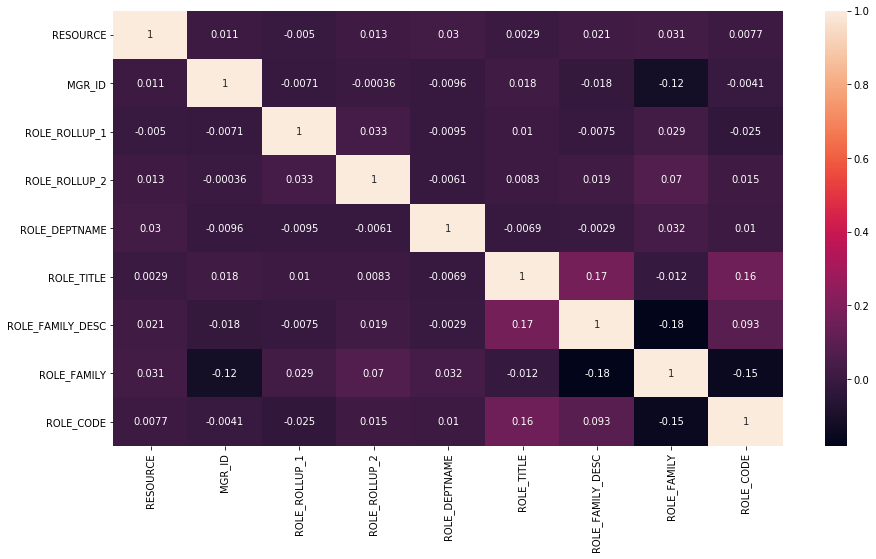

In [14]:
plt.figure(figsize=(15, 8))
sns.heatmap(emp.corr(),annot=True)

As clearly visible, multicollinearity between feature variables is not present.

#### Split the data into traning and testing dataset.

In [15]:
from sklearn.model_selection import train_test_split
def log():
    return train_test_split(X, y, test_size=0.25, random_state=1)
X_train, X_test, y_train, y_test = log()

In [16]:
# Shape of each training and testing dataset
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24576, 9)
(24576, 1)
(8193, 9)
(8193, 1)


<a id="section401"></a>
### 4.1. Model building using random forest and evaluation

In [17]:
# Instantiating Random Forest Classifier using scikit learn with default parameters.
from sklearn.ensemble import RandomForestClassifier
def me():
    rf=RandomForestClassifier()
    return rf
rf = me()

In [18]:
# Fitting the model on X_train and y_train
rf.fit(X_train,y_train)

C:\Users\91900\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\91900\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
# Using the model for prediction
predictions_rf = pd.DataFrame()
predictions_rf=rf.predict(X_test)

#### Model evalation:

In [20]:
# Calculating the accuracy score  
from sklearn.metrics import accuracy_score
def me():
    print(accuracy_score(y_test, predictions_rf))
me()

0.9437324545343586


In [21]:
# Calculating the confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix = pd.DataFrame(confusion_matrix(y_test, predictions_rf))
confusion_matrix.index=['Actual Rejected','Actual Approved']
confusion_matrix.columns=['Predicted Rejected','Predicted Approved']
print(confusion_matrix)

                 Predicted Rejected  Predicted Approved
Actual Rejected                 186                 277
Actual Approved                 184                7546


In [22]:
# Calculate recall, precision and F1 score

from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_test,predictions_rf))
print(recall_score(y_test,predictions_rf))
print(f1_score(y_test,predictions_rf))

0.9645915889045124
0.9761966364812419
0.9703594161898026


0.8022138927462775


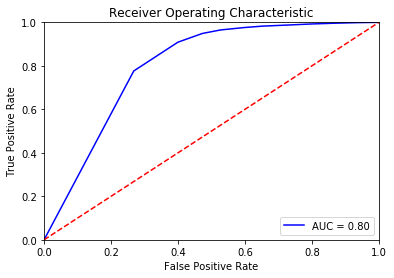

In [23]:
# Calculate the area under curve
from sklearn import metrics
probs1=rf.predict_proba(X_test)
pred1 = probs1[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred1)
roc_auc1 = metrics.auc(fpr, tpr)
print(roc_auc1)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a id="section402"></a>
### 4.2. Model building using random forest with different hyperparameters and model evaluation

#### Instantiating Random Forest Classifier using scikit learn with:

- random_state = 0,
- max_depth = 2, 
- min_samples_leaf = 3,
- min_samples_split = 4,
- max_leaf_nodes=5, 
- class_weight=balanced,
- n_estimators = 100

In [24]:
from sklearn.ensemble import RandomForestClassifier
def me():
    # instantiate RandomForestClassifier as rfc
    rfc=RandomForestClassifier(criterion='entropy',n_estimators = 100, random_state = 0, max_depth = 2, min_samples_split=4, min_samples_leaf=3, max_leaf_nodes=5, class_weight='balanced')
    return rfc
rfc = me()

In [25]:
# Fitting the model on X_train and y_train
rfc.fit(X_train,y_train)

C:\Users\91900\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=5, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=4, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [26]:
# Using the model for prediction
predictions_rf1=pd.DataFrame()
predictions_rf1=rfc.predict(X_test)

In [27]:
# Calculating the confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix = pd.DataFrame(confusion_matrix(y_test, predictions_rf1))
confusion_matrix.index=['Actual Rejected','Actual Approved']
confusion_matrix.columns=['Predicted Rejected','Predicted Approved']
print(confusion_matrix)

                 Predicted Rejected  Predicted Approved
Actual Rejected                 253                 210
Actual Approved                2694                5036


In [28]:
# Calculating the precision, recall and f1 score

from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_test,predictions_rf1))
print(recall_score(y_test,predictions_rf1))
print(f1_score(y_test,predictions_rf1))

0.9599695005718643
0.6514877102199224
0.7762022194821208


0.8022138927462775


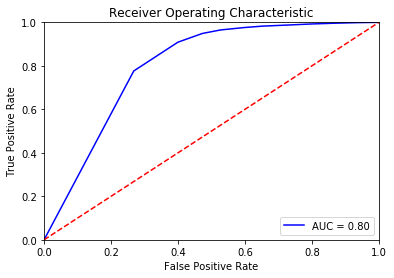

In [29]:
# Calculating the area under curve

from sklearn import metrics
probs2=rfc.predict_proba(X_test)
pred2 = probs1[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred2)
roc_auc2 = metrics.auc(fpr, tpr)
print(roc_auc2)

# Plotting the AUC ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
# Calculating the accuracy score  

print(accuracy_score(y_test, predictions_rf1))

0.6455510801904064


<a id="section403"></a>
### 4.3. Model building using decision tree and evaluation

In [31]:
# Instantiate DecisionTreeClassifier to a variable dt

from sklearn.tree import DecisionTreeClassifier
def me():
    dt=DecisionTreeClassifier()
    return dt
dt = me()

In [32]:
# Fitting the model on X train and y train
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [33]:
# Using the model for prediction
predictions_dt1 = pd.DataFrame()
predictions_dt1=dt.predict(X_test)

In [34]:
# Calculating the confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix = pd.DataFrame(confusion_matrix(y_test, predictions_dt1))
confusion_matrix.index=['Actual Rejected','Actual Approved']
confusion_matrix.columns=['Predicted Rejected','Predicted Approved']
print(confusion_matrix)

                 Predicted Rejected  Predicted Approved
Actual Rejected                 206                 257
Actual Approved                 345                7385


In [35]:
# Calculating precision score, recall score, f1 score and accuracy score

from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_test,predictions_dt1))
print(recall_score(y_test,predictions_dt1))
print(f1_score(y_test,predictions_dt1))
print(accuracy_score(y_test, predictions_dt1))

0.9663700601936666
0.9553686934023286
0.9608378870673953
0.9265226412791407


0.7001465497249224


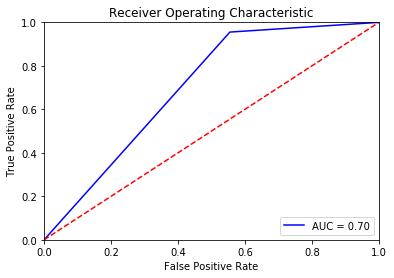

In [36]:
# Calculating area under curve and plotting the curve for AUC ROC

from sklearn import metrics
probs3=dt.predict_proba(X_test)
pred3 = probs3[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred3)
roc_auc3 = metrics.auc(fpr, tpr)
print(roc_auc3)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a id="section404"></a>
### 4.4 Model building using logistic regression and evaluation

In [37]:
# instantiate LogisticRegression as logr

from sklearn.linear_model import LogisticRegression
def me():
    logr=LogisticRegression()
    return logr
logr = me()

In [38]:
# Fitting the model on X train and y train

logr.fit(X_train, y_train)

C:\Users\91900\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\91900\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
# Using the model for prediction on X test

predictions_logr=pd.DataFrame()
predictions_logr=logr.predict(X_test)

In [40]:
# Calculating the accuracy score, recall, precision and f1 score

print(accuracy_score(y_test, predictions_logr))
print(recall_score(y_test, predictions_logr))
print(precision_score(y_test, predictions_logr))
print(f1_score(y_test, predictions_logr))

0.9434883437080435
1.0
0.9434883437080435
0.9709225648433084


In [41]:
# Calculating the confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix = pd.DataFrame(confusion_matrix(y_test, predictions_logr))
confusion_matrix.index=['Actual Rejected','Actual Approved']
confusion_matrix.columns=['Predicted Rejected','Predicted Approved']
print(confusion_matrix)

                 Predicted Rejected  Predicted Approved
Actual Rejected                   0                 463
Actual Approved                   0                7730


0.7001465497249224


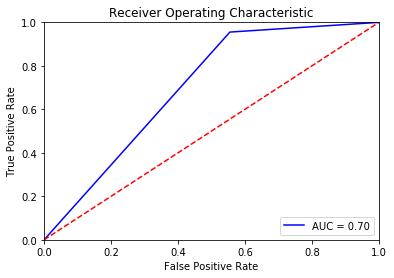

In [43]:
# Calculating the area under the curve and further pliotting the curve for the AUC-ROC.
from sklearn import metrics
probs4=dt.predict_proba(X_test)
pred4 = probs4[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred4)
roc_auc4 = metrics.auc(fpr, tpr)
print(roc_auc4)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a id="section405"></a>
### 4.5 Choosing better model using ROC_AUC curve

We have compared the performance of the 4 models using various model evaluation techinques.<br/>
In this case, we are not concerned with high false postive or high false negative values.
We should concentrate on predicting 0s as 0 and 1s as 1.
Drawing the analogy here, we should concentrate on predicting rejections as rejection and approvals as approval.

- AUC score for model1(Using RandomForestClassifier) is: __0.8022__
- AUC score for model2(Using RandomForestClassifier with different hyperparameters) is: __0.8022__
- AUC score for model3(Using DecisionTreeClassifier) is: __0.7001__
- AUC score for model4(Using RandomForestClassifier) is: __0.0.7001__
    
As AUC score of model1 and model2 is __better__ than that of any other models, let us see whose F1 score is highest among these 2._

- F1 score for model1(Using RandomForestClassifier) is: __0.9703__
- F1 score for model2(Using RandomForestClassifier with different hyperparameters) is: __0.7762__
    

So, we will go with model 1.